# <span style="color:#0b486b">  FIT5215: Deep Learning (2023)</span>
***
*CE/Lecturer:* Dr **Trung Le** | trunglm@monash.edu <br/>
*Head Tutor:* Mr **Tuan Nguyen** | tuan.nguyen@monash.edu <br/>
<br/>
Department of Data Science and AI, Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
Surname: **NG**  <br/>
Firstname: **YI JIE**    <br/>
Student ID: **31158145**    <br/>
Email: **yngg0039@student.monash.edu**    <br/>
Your tutorial time: **Monday 10.00am to 12.00pm**    <br/>
***

## <span style="color:#0b486b">Assignment 02: Neural Embedding and Sequence Modelling</span>
### Due: <span style="color:red">11:59pm 22 October 2023</span>  (Sunday)

#### <span style="color:red">Important note:</span> This is an **individual** assignment. It contributes **20%** to you final mark. Read the assignment instruction carefully.

## <span style="color:#0b486b">Instructions</span>

This notebook has been prepared for your to complete Assignment 2. The theme of this assignment is about practical machine learning knowledge and skills in deep neural networks, word embedding and text analytics. Some sections have been partially completed to help you get
started. **The total marks for this notebook is 100**.

* Before you start, read the entire notebook carefully once to understand what you need to do. <br><br>
* For each cell marked with **#YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL**, there will be places where you **must** supply your own codes when instructed. <br>

This assignment contains **four** parts:

* Part 1: Questions on downloading and preprocessing data **[5 points]**
* Part 2: Questions on using Word2Vect to transform texts to vectors **[20 points]**
* Part 3: Coding assessment on BERT and CLIP for a feature extraction **[15 points]**
* Part 4: Coding assessment on RNNs for sequence modeling and neural embedding **[60 points]**


**Hint**: This assignment was essentially designed based on the lectures and tutorials sessions covered from Weeks 6 to 10. You are strongly recommended to go through these contents thoroughly which might help you to complete this assignment.

## <span style="color:#0b486b">What to submit</span>

This assignment is to be completed individually and submitted to Moodle unit site. **By the due date, you are required to submit one  <span style="color:red; font-weight:bold">single zip file, named xxx_assignment02_solution.zip</span> where `xxx` is your student ID, to the corresponding Assignment (Dropbox) in Moodle**. 

***For example, if your student ID is <span style="color:red; font-weight:bold">12356</span>, then gather all of your assignment solution to folder, create a zip file named <span style="color:red; font-weight:bold">123456_assignment02_solution.zip</span> and submit this file.***

Within this zip folder, you **must** submit the following files:
1.	**Assignment02_solution.ipynb**:  this is your Python notebook solution source file.
1.	**Assignment02_output.html**: this is the output of your Python notebook solution *exported* in html format.
1.	Any **extra files or folder** needed to complete your assignment (e.g., images used in your answers).

## <span style="color:#0b486b">Set random seeds</span>

We start with importing tensorflow and numpy and setting random seeds for TF and numpy. You can use any seeds you prefer.

In [1]:
import numpy as np
import tensorflow as tf
tf.random.set_seed(6789)
np.random.seed(6789)

## <span style="color:#0b486b">Part 1: Download and preprocess the data</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 5 points]<span></div>

The dataset we use for this assignment is a question classification dataset for which the train set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR), 
- entity (ENTY), 
- description (DESC), 
- human (HUM), 
- location (LOC) and 
- numeric (NUM).


Preprocessing data is an inital and important step in any machine learning or deep learning projects. The following *DataManager* class helps you to download data and preprocess data for the later questions of this assignment. 

In [2]:
import os
import zipfile
import collections
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

class DataManager:
    def __init__(self, verbose=True, maxlen= 50, random_state=6789):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_questions = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.maxlen = maxlen
        self.numeral_data = list()
        self.random_state = random_state
        self.random = np.random.RandomState(random_state)
        
    @staticmethod
    def maybe_download(dir_name, file_name, url, verbose= True):
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        if not os.path.exists(os.path.join(dir_name, file_name)):
            urlretrieve(url + file_name, os.path.join(dir_name, file_name))
        if verbose:
            print("Downloaded successfully {}".format(file_name))
    
    def read_data(self, dir_name, file_names):
        self.str_questions= list(); self.str_labels= list()
        for file_name in file_names:
            file_path= os.path.join(dir_name, file_name)
            with open(file_path, "r", encoding="latin-1") as f:
                for row in f:
                    row_str= row.split(":")
                    label, question= row_str[0], row_str[1]
                    question= question.lower()
                    self.str_labels.append(label)
                    self.str_questions.append(question[0:-1])
                    if self.max_sentence_len < len(self.str_questions[-1]):
                        self.max_sentence_len= len(self.str_questions[-1])
         
        # turns labels into numbers
        le= preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes= le.classes_
        self.num_classes= len(self.str_classes)
        if self.verbose:
            print("\nSample questions... \n")
            print(self.str_questions[0:5])
            print("Labels {}\n\n".format(self.str_classes))
    
    def manipulate_data(self):
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(self.str_questions)
        # convert texts to sequence of indices so we can put into embedding layer
        self.numeral_data = tokenizer.texts_to_sequences(self.str_questions) 
        # padding for seq length
        self.numeral_data = tf.keras.preprocessing.sequence.pad_sequences(self.numeral_data, padding='post', truncating= 'post', maxlen= self.maxlen)
        self.word2idx = tokenizer.word_index
        self.word2idx = {k:v for k,v in self.word2idx.items()}
        self.idx2word = {v:k for k,v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
    
    def train_valid_split(self, train_ratio=0.9):
        idxs = np.random.permutation(np.arange(len(self.str_questions)))
        train_size = int(train_ratio*len(idxs)) +1
        self.train_str_questions, self.valid_str_questions = self.str_questions[0:train_size], self.str_questions[train_size:]
        self.train_numeral_data, self.valid_numeral_data = self.numeral_data[0:train_size], self.numeral_data[train_size:]
        self.train_numeral_labels, self.valid_numeral_labels = self.numeral_labels[0:train_size], self.numeral_labels[train_size:]
        self.tf_train_set = tf.data.Dataset.from_tensor_slices((self.train_numeral_data, self.train_numeral_labels))
        self.tf_valid_set = tf.data.Dataset.from_tensor_slices((self.valid_numeral_data, self.valid_numeral_labels))


In [3]:
print('Loading data...')
DataManager.maybe_download("Data", "train_1000.label", "http://cogcomp.org/Data/QA/QC/")
DataManager.maybe_download("Data", "TREC_10.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("Data/", ["train_1000.label", "TREC_10.label"])   # read data
# If you want to play around with a bigger dataset, you can try train_set.label

Loading data...
Downloaded successfully train_1000.label
Downloaded successfully TREC_10.label

Sample questions... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
Labels ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']




In [4]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

#### <span style="color:red">**Question 1.1**</span> 
**What is the purpose of `self.train_str_questions` and `self.train_numeral_labels`? Write your code to print out the first five questions with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

#Your answer here




self.train_str_questions: the original string data to be trained which splitted from the datasets. 

self.train_numeral_labels: the label for the corresponding train data representing in numerical form transformed from string label.

In [5]:
#Your code here
for i in range(5):
    print("+ Text: {}\n+ Label: {} ({})\n".format(dm.train_str_questions[i], dm.str_labels[i], dm.train_numeral_labels[i]))

+ Text: manner how did serfdom develop in and then leave russia ?
+ Label: DESC (1)

+ Text: cremat what films featured the character popeye doyle ?
+ Label: ENTY (2)

+ Text: manner how can i find a list of celebrities ' real names ?
+ Label: DESC (1)

+ Text: animal what fowl grabs the spotlight after the chinese year of the monkey ?
+ Label: ENTY (2)

+ Text: exp what is the full form of .com ?
+ Label: ABBR (0)



#### <span style="color:red">**Question 1.2**</span> 
**What is the purpose of `self.train_numeral_data`? Write your code to print out the first five questions in the numeric format with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

#Your answer here




self.train_numeral_data: To convert texts to sequence of indices so we can put into embedding layer

In [6]:
#Your code here
for i in range(5):
    print("+ Data: {}\n+ Label: {} ({})\n".format(dm.train_numeral_data[i], dm.str_labels[i], dm.train_numeral_labels[i]))

+ Data: [  35   11   18 1030 1031    5   25  561 1032  562    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
+ Label: DESC (1)

+ Data: [  43    2  563 1033    1  164 1034 1035    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0

#### <span style="color:red">**Question 1.3**</span> 
**What is the purpose of two dictionaries: `self.word2idx` and `self.idx2word`? Write your code to print out the first five key-value pairs of those dictionaries.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

#Your answer here

 



self.word2idx: build a dictionary which maps the word to an unique id in numerical form

self.idx2word: build a dictionary which allows reverse mapping from numerical id to word

In [7]:
#Your code here
for i in range(5):
    print("+ key-value pair {} : {}".format(i+1, list(dm.word2idx.items())[i])) 
print()
for i in range(5):
    print("+ key-value pair {} : {}".format(i+1, list(dm.idx2word.items())[i])) 

+ key-value pair 1 : ('the', 1)
+ key-value pair 2 : ('what', 2)
+ key-value pair 3 : ('is', 3)
+ key-value pair 4 : ('of', 4)
+ key-value pair 5 : ('in', 5)

+ key-value pair 1 : (1, 'the')
+ key-value pair 2 : (2, 'what')
+ key-value pair 3 : (3, 'is')
+ key-value pair 4 : (4, 'of')
+ key-value pair 5 : (5, 'in')


#### <span style="color:red">**Question 1.4**</span> 
**What is the purpose of `self.tf_train_set`? Write your code to print out the first five items of `self.tf_train_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

#Your answer here



self.tf_train_set: convert the training set data from numpy to tf.keras for preprocessing purpose. Representation of tf.keras enhance the performance of RNN compared to tf.keras. 

In [8]:
#Your code here
my_items = dm.tf_train_set.take(5)
counter = 0
for data, label in my_items:
    print("+ data : {}".format(data))
    print("+ label: {} ({})\n".format(dm.str_labels[counter], label))
    counter += 1

+ data : [  35   11   18 1030 1031    5   25  561 1032  562    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
+ label: DESC (1)

+ data : [  43    2  563 1033    1  164 1034 1035    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   

#### <span style="color:red">**Question 1.5**</span> 
**What is the purpose of `self.tf_valid_set`? Write your code to print out the first five items of `self.tf_valid_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

#Your answer here



self.tf_valid_set: Similar to the previous question, valid set data represented in tf.keras enhance the performance of RNN.

In [9]:
#Your code here
my_items = dm.tf_valid_set.take(5)
counter = 0
for data, label in my_items:
    print("+ data : {}".format(data))
    print("+ label: {} ({})\n".format(dm.str_labels[counter], label))
    counter += 1

+ data : [  23    2   23   13  243    3   53    1 3031   20    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
+ label: DESC (4)

+ data : [   6   12   98    1 3032    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   

## <span style="color:#0b486b">Part 2: Using Word2Vect to transform texts to vectors </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 20 points]<span></div>

In this part, you will be assessed on how to use a pretrained Word2Vect model for realizing a machine learning task. Basically, you will use this pretrained Word2Vect to transform the questions in the above dataset stored in the *data manager object dm* to numeric form for training a Support Vector Machine in sckit-learn.  

In [10]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

#### <span style="color:red">**Question 2.1**</span> 
**Write code to download the pretrained model *glove-wiki-gigaword-100*. Note that this model transforms a word in its dictionary to a $100$ dimensional vector.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [11]:
word2vect = api.load("glove-wiki-gigaword-100") 

#### <span style="color:red">**Question 2.2**</span> 

**Write code for the function *get_word_vector(word, model)* used to transform a word to a vector using the pretrained Word2Vect model *model*. Note that for a word not in the vocabulary of our *word2vect*, you need to return a vector $0$ with 100 dimensions.**

<div style="text-align: right"><span style="color:red">[3 points]</span></div> 

In [12]:
def get_word_vector(word, model):
    try:
        vector = model.get_vector(word) #Insert your code here
    except: #word not in the vocabulary
        vector = np.zeros(100) #Insert your code here
    return vector

#### <span style="color:red">**Question 2.3**</span> 

**Write the code for the function `get_sentence_vector(sentence, important_score=None, model= None)`. Note that this function will transform a sentence to a 100-dimensional vector using the pretrained model *model*. In addition, the list *important_score* which has the same length as the *sentence* specifies the important scores of the words in the sentence. In your code, you first need to apply *softmax* function over *important_score* to obtain the important weight *important_weight* which forms a probability over the words of the sentence. Furthermore, the final vector of the sentence will be weighted sum of the individual vectors for words and the weights in *important_weight*.**
- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[L]\times v[L]$ where $L$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if `important_score=None` is set by default, your function should return the average of all representation vectors corresponding to set `important_score=[1,1,...,1]`.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div> 

In [13]:
import math

def get_sentence_vector(sentence, important_score=None, model= None):
    #Insert your code here
    # code for checking important score and make the corresponding adjustment 
    if important_score == None:
        important_score = np.zeros(len(sentence))
        for x in range(len(sentence)):
            important_score[x] = 1
  
    important_weight = np.zeros(len(important_score))
    sum_values = 0
    for x in important_score:
        sum_values += (math.exp(x))

    for y in range(len(important_weight)):
        important_weight[y] = math.exp(important_score[y])/sum_values
    
    
    final_vector = 0
    for z in range(len(sentence)):
        final_vector += (important_weight[z] * get_word_vector(sentence[z], model))
    
    return final_vector

#### <span style="color:red">**Question 2.4**</span> 

**Write code to transform the training questions in *dm.train_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_train$ which is an numpy array of the feature vectors and $y\_train$ which is an array of numeric labels (*Hint: dm.train_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [14]:
print("Transform training set to feature vectors...")

my_train_data = dm.train_str_questions
X_train = []
y_train = []
for x in range(len(my_train_data)):
    my_important_score = []
    important_decay = 1
    for _ in range(len(my_train_data[x])):
        my_important_score.append(1 * important_decay)
        important_decay *= 0.9 
    X_train.append(get_sentence_vector(my_train_data[x], important_score=my_important_score, model= word2vect)) #Insert your code here
    y_train.append(dm.train_numeral_labels[x]) #Insert your code here

X_train = np.array(X_train)
y_train = np.array(y_train)

print(np.array(X_train))
print(np.array(y_train))

Transform training set to feature vectors...
[[-0.40567002  0.2688511   0.12303752 ... -0.43452567  0.19864938
  -0.16978675]
 [-0.28863415  0.30026314 -0.0052233  ... -0.45679647  0.19918853
  -0.16561505]
 [-0.33047596  0.28323042  0.12037525 ... -0.42717263  0.20406398
  -0.08336753]
 ...
 [-0.24968223  0.31919044  0.05838137 ... -0.47703868  0.19080877
  -0.1612748 ]
 [-0.17755428  0.3741416   0.15206659 ... -0.44778585  0.20509894
  -0.09373724]
 [-0.24023077  0.30256766  0.05137032 ... -0.4385511   0.14719903
  -0.08514029]]
[1 2 1 ... 2 2 2]


#### <span style="color:red">**Question 2.5**</span> 

**Write code to transform the training questions in *dm.valid_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_valid$ which is an numpy array of the feature vectors and $y\_valid$ which is an array of numeric labels (*Hint: dm.valid_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [15]:
print("Transform valid set to feature vectors...")

my_valid_data = dm.valid_str_questions
X_valid = []
y_valid = []
for x in range(len(my_valid_data)):
    my_important_score = []
    important_decay = 1
    for _ in range(len(my_valid_data[x])):
        my_important_score.append(1 * important_decay)
        important_decay *= 0.9 
    X_valid.append(get_sentence_vector(my_valid_data[x], important_score=my_important_score, model= word2vect)) #Insert your code here
    y_valid.append(dm.valid_numeral_labels[x]) #Insert your code here

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

print(np.array(X_valid))
print(np.array(y_valid))


Transform valid set to feature vectors...
[[-0.23445489  0.3181257   0.12655434 ... -0.49905512  0.16277237
  -0.05210152]
 [-0.3950443   0.3186724   0.12786128 ... -0.44719163  0.07332351
  -0.06822883]
 [-0.27865553  0.30705094  0.03221839 ... -0.418756    0.24763444
  -0.06873033]
 ...
 [-0.24255916  0.26358387  0.03819679 ... -0.4927542   0.09138148
  -0.10298856]
 [-0.19213279  0.35176507  0.1104513  ... -0.48998827  0.11405569
  -0.11363636]
 [-0.3453338   0.36885926  0.10538714 ... -0.4810923   0.1602331
  -0.08486876]]
[4 3 2 5 4 3 5 1 1 5 5 4 4 1 2 1 2 5 1 1 5 1 2 4 2 5 1 4 3 5 3 1 5 2 1 4 1
 4 5 4 1 1 1 1 4 1 1 1 2 3 4 2 2 1 4 5 2 1 5 3 3 5 2 5 1 1 4 5 1 2 1 1 3 1
 1 1 5 0 2 4 3 0 1 4 1 1 1 1 1 4 2 5 2 1 1 2 5 2 2 0 5 1 5 5 4 3 4 3 5 4 4
 5 1 4 1 3 4 2 4 1 5 0 2 5 0 1 5 5 1 1 5 2 2 5 4 1 2 1 5 5 2 5 3 5 3 2 1 5
 1 5 4 2 2 1 3 5 5 1 2 1 1 2 5 1 5 2 2 1 4 5 2 1 1 2 5 4 1 0 1 3 3 2 3 5 5
 1 3 1 1 3 1 2 5 1 1 1 5 5 4 3 2 5 0 5 4 1 4 5 1 3 2 4 0 2 1 1 1 3 3 5 4 2
 1 4 2 1 4 1 3 1 

#### <span style="color:red">**Question 2.6**</span> 

**It is now to use *MinMaxScaler(feature_range=(-1,1))* in sckit-learn to scale both training and valid sets to the range $(-1,1)$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [16]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)#Insert your code here
scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)#Insert your code here

#### <span style="color:red">**Question 2.7**</span> 

**Declare a support vector machine (the class *SVC*  in sckit-learn) with RBF kernel, $C=1$, $gamma= 2^{-3}$ and fit on the training set.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [17]:
svm = SVC(kernel='rbf', C=1, gamma=2**-3)
#Insert your code for fitting svm on X_train

# Fit the classifier on the training data
svm.fit(X_train, y_train)

SVC(C=1, gamma=0.125)

#### <span style="color:red">**Question 2.8**</span> 

**Finally, we use the trained *svm* to evaluate on the valid set $X\_valid$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [18]:
y_valid_pred= svm.predict(X_valid) #Insert your code
acc = accuracy_score(y_valid_pred, y_valid) #Insert your code
print(acc)

0.822742474916388


## <span style="color:#0b486b">Part 3: Sentence representation with BERT and CLIP </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 15 points]<span></div>

#### <span style="color:red">**Question 3.1**</span>
**Use a pretrained BERT model to extract feaure vectors for the training and valid sets. You should choose an appropriate pretrained BERT model that fits your computational resource.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [19]:
# !pip install -U tensorflow-text -q --progress-bar off
# !pip install tf-models-official -q --progress-bar off


In [20]:
import os
import shutil
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

global_seed = 123
np.random.seed(global_seed)
tf.random.set_seed(global_seed)

C:\Users\ngyij\anaconda3\envs\my_tf2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\ngyij\anaconda3\envs\my_tf2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [21]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [22]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

train_text_preprocessed = bert_preprocess_model(dm.train_str_questions)
valid_text_preprocessed = bert_preprocess_model(dm.valid_str_questions)

In [23]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
train_bert_results = bert_model(train_text_preprocessed)
valid_bert_results = bert_model(valid_text_preprocessed)

#### <span style="color:red">**Question 3.2**</span>
**Conduct a feed-forward neural network to train on the training set of feature vectors extracted from BERT and then evaluate on the valid set.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [24]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(train_bert_results['pooled_output'].shape[1]))
    net = text_input
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [25]:
classifier_model = build_classifier_model()

In [26]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(dm.tf_train_set).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [27]:
classifier_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy"])

train_data = (train_bert_results['pooled_output'])
valid_data = (valid_bert_results['pooled_output'])

history = classifier_model.fit(x = train_data, y = dm.train_numeral_labels,
                               validation_data=(valid_data, dm.valid_numeral_labels), 
                               epochs=epochs)


Epoch 1/3
38/38 [==============================] - 0s 6ms/step - loss: 2.5102 - accuracy: 0.1182 - val_loss: 2.4563 - val_accuracy: 0.1906
Epoch 2/3
38/38 [==============================] - 0s 2ms/step - loss: 2.4957 - accuracy: 0.1182 - val_loss: 2.4426 - val_accuracy: 0.1906
Epoch 3/3
38/38 [==============================] - 0s 2ms/step - loss: 2.4687 - accuracy: 0.1207 - val_loss: 2.4202 - val_accuracy: 0.1906


In [28]:
loss, accuracy = classifier_model.evaluate(valid_data,  dm.valid_numeral_labels)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

10/10 [==============================] - 0s 834us/step - loss: 2.4202 - accuracy: 0.1906
Loss: 2.42022442817688
Accuracy: 0.19063545763492584


#### <span style="color:red">**Question 3.3**</span>
**Use a pretrained CLIP model to extract feaure vectors for the training and valid sets. You should choose an appropriate pretrained CLIP model that fits your computational resource.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [29]:
# !pip install transformers
from transformers import CLIPProcessor, CLIPModel
from transformers import AutoTokenizer, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

C:\Users\ngyij\anaconda3\envs\my_tf2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
train_inputs = tokenizer(dm.train_str_questions, padding=True, return_tensors="pt")
train_text_features = model.get_text_features(**train_inputs).detach().numpy()

valid_inputs = tokenizer(dm.valid_str_questions, padding=True, return_tensors="pt")
valid_text_features = model.get_text_features(**valid_inputs).detach().numpy()


#### <span style="color:red">**Question 3.4**</span>
**Conduct a feed-forward neural network to train on the training set of feature vectors extracted from CLIP and then evaluate on the valid set.**
<div style="text-align: right"><span style="color:red">[3 points]</span></div>

In [31]:
#Insert your code for training here
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

nn_model = keras.Sequential([
    keras.layers.Input(shape=train_text_features.shape[1]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(6, activation="softmax")  
])

# Compile the model
nn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

epochs = 10  
batch_size = 32
nn_model.fit(train_text_features, dm.train_numeral_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/10
30/30 [==============================] - 1s 7ms/step - loss: 1.3104 - accuracy: 0.5583 - val_loss: 0.8240 - val_accuracy: 0.8008
Epoch 2/10
30/30 [==============================] - 0s 2ms/step - loss: 0.6137 - accuracy: 0.8229 - val_loss: 0.4797 - val_accuracy: 0.8506
Epoch 3/10
30/30 [==============================] - 0s 2ms/step - loss: 0.3068 - accuracy: 0.9229 - val_loss: 0.3610 - val_accuracy: 0.8755
Epoch 4/10
30/30 [==============================] - 0s 2ms/step - loss: 0.1634 - accuracy: 0.9646 - val_loss: 0.3151 - val_accuracy: 0.8880
Epoch 5/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0872 - accuracy: 0.9917 - val_loss: 0.3197 - val_accuracy: 0.8921
Epoch 6/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9979 - val_loss: 0.2795 - val_accuracy: 0.9046
Epoch 7/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 0.9990 - val_loss: 0.2824 - val_accuracy: 0.8963
Epoch 8/10
30/30 [==

In [32]:
#Insert your code for testing here
valid_predictions = nn_model.predict(valid_text_features)
valid_predictions = np.argmax(valid_predictions, axis=-1)
accuracy = accuracy_score(dm.valid_numeral_labels, valid_predictions)

print("Validation Accuracy:{}".format(accuracy))

10/10 [==============================] - 0s 946us/step
Validation Accuracy:0.919732441471572


## <span style="color:#0b486b">Part 4: RNNs for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 60 points]<span></div>

### <span style="color:#0b486b">4.1. One-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.1.1**</span> 
**In this part, you need to construct an RNN to learn from the dataset of interest. Basically, you are required first to construct the class UniRNN (Uni-directional RNN) with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can receive three values including `basic_rnn`, `gru`, and `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Note that when declaring an embedding layer for the network, you need to set *mask_zero=True* so that the padding zeros in the sentences will be masked and ignored. This helps to have variable length RNNs. For more detail, you can refer to this [link](https://www.tensorflow.org/guide/keras/masking_and_padding).**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [33]:
class UniRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1 
        self.word2idx = self.data_manager.word2idx
        self.embed_matrix = np.zeros((self.vocab_size, self.embed_size))
        
        self.model = None
        
    #return the correspoding memory cell
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            return tf.keras.layers.GRU(state_size, return_sequences=return_sequences)
        elif cell_type== 'lstm':
            return tf.keras.layers.LSTM(state_size, return_sequences=return_sequences)
        else:
            return tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences)
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        h = self.embedding_layer(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            if i != num_layers-1:
                h = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i], return_sequences= True)(h)
            else:
                h = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i])(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
   
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.1.2**</span> 
**Run with basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [34]:
uni_rnn = UniRNN(cell_type= 'basic_rnn', embed_size= 128, state_sizes= [64,128], data_manager= dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 3s 74ms/step - loss: 1.0381 - accuracy: 0.6386 - val_loss: 0.4139 - val_accuracy: 0.9030
Epoch 2/10
19/19 [==============================] - 1s 60ms/step - loss: 0.2185 - accuracy: 0.9500 - val_loss: 0.2415 - val_accuracy: 0.9365
Epoch 3/10
19/19 [==============================] - 1s 61ms/step - loss: 0.1056 - accuracy: 0.9725 - val_loss: 0.2295 - val_accuracy: 0.9365
Epoch 4/10
19/19 [==============================] - 1s 60ms/step - loss: 0.0580 - accuracy: 0.9875 - val_loss: 0.1835 - val_accuracy: 0.9398
Epoch 5/10
19/19 [==============================] - 1s 59ms/step - loss: 0.0179 - accuracy: 0.9958 - val_loss: 0.1683 - val_accuracy: 0.9532
Epoch 6/10
19/19 [==============================] - 1s 60ms/step - loss: 0.0381 - accuracy: 0.9900 - val_loss: 0.3058 - val_accuracy: 0.9164
Epoch 7/10
19/19 [==============================] - 1s 60ms/step - loss: 0.0085 - accuracy: 0.9992 - val_loss: 0.1032 - val_accuracy: 0.9632
Epoch 8/10
19

#### <span style="color:red">**Question 4.1.3**</span> 
**Run with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [35]:
uni_rnn = UniRNN(cell_type= 'gru', embed_size= 128, state_sizes= [64,128], data_manager= dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 7s 171ms/step - loss: 1.5809 - accuracy: 0.3514 - val_loss: 1.1088 - val_accuracy: 0.6054
Epoch 2/10
19/19 [==============================] - 2s 95ms/step - loss: 0.6956 - accuracy: 0.7410 - val_loss: 0.4939 - val_accuracy: 0.8562
Epoch 3/10
19/19 [==============================] - 2s 95ms/step - loss: 0.2301 - accuracy: 0.9351 - val_loss: 0.2653 - val_accuracy: 0.9097
Epoch 4/10
19/19 [==============================] - 2s 95ms/step - loss: 0.1082 - accuracy: 0.9642 - val_loss: 0.1951 - val_accuracy: 0.9197
Epoch 5/10
19/19 [==============================] - 2s 95ms/step - loss: 0.0418 - accuracy: 0.9900 - val_loss: 0.2181 - val_accuracy: 0.9431
Epoch 6/10
19/19 [==============================] - 2s 95ms/step - loss: 0.0190 - accuracy: 0.9958 - val_loss: 0.1791 - val_accuracy: 0.9398
Epoch 7/10
19/19 [==============================] - 2s 95ms/step - loss: 0.0104 - accuracy: 0.9983 - val_loss: 0.1771 - val_accuracy: 0.9398
Epoch 8/10
1

#### <span style="color:red">**Question 4.1.4**</span> 
**Run with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [36]:
uni_rnn = UniRNN(cell_type= 'lstm', embed_size= 128, state_sizes= [64,128], data_manager= dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 7s 176ms/step - loss: 1.4114 - accuracy: 0.4771 - val_loss: 0.9502 - val_accuracy: 0.8194
Epoch 2/10
19/19 [==============================] - 2s 104ms/step - loss: 0.4285 - accuracy: 0.9026 - val_loss: 0.3325 - val_accuracy: 0.9097
Epoch 3/10
19/19 [==============================] - 2s 105ms/step - loss: 0.1793 - accuracy: 0.9409 - val_loss: 0.2080 - val_accuracy: 0.9130
Epoch 4/10
19/19 [==============================] - 2s 104ms/step - loss: 0.1045 - accuracy: 0.9675 - val_loss: 0.1735 - val_accuracy: 0.9431
Epoch 5/10
19/19 [==============================] - 2s 110ms/step - loss: 0.0629 - accuracy: 0.9867 - val_loss: 0.1494 - val_accuracy: 0.9431
Epoch 6/10
19/19 [==============================] - 2s 105ms/step - loss: 0.0352 - accuracy: 0.9908 - val_loss: 0.1060 - val_accuracy: 0.9632
Epoch 7/10
19/19 [==============================] - 2s 105ms/step - loss: 0.0168 - accuracy: 0.9992 - val_loss: 0.1351 - val_accuracy: 0.9565
Epoch 

### <span style="color:#0b486b">4.2. Bi-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.2.1**</span> 
**In what follow, you will investigate BiRNN. The task is similar to Part 5.1 but you need to write the code for an BiRNN. Note that the function *get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh')* has to return the hidden layer with bidirectional memory cells (e.g., Basic RNN, GRU, and LSTM cells).**

**Complete the code of the class *BiRNN*. Note that for the embedding layer you need to set *mask_zero=True*.**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [37]:
class BiRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1 
        self.word2idx = self.data_manager.word2idx
        self.embed_matrix = np.zeros((self.vocab_size, self.embed_size))
        
        self.model = None
        
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size, return_sequences=return_sequences))
        elif cell_type== 'lstm':
            return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, return_sequences=return_sequences))
        else:
            return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences))
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        h = self.embedding_layer(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            if i != num_layers-1:
                h = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i], return_sequences= True)(h)
            else:
                h = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i])(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.2.2**</span> 
**Run BiRNN for basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [38]:
bi_rnn = BiRNN(cell_type= 'basic_rnn', embed_size= 128, state_sizes= [64,128], data_manager= dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 5s 134ms/step - loss: 0.6736 - accuracy: 0.7927 - val_loss: 0.2606 - val_accuracy: 0.9231
Epoch 2/10
19/19 [==============================] - 2s 116ms/step - loss: 0.1013 - accuracy: 0.9675 - val_loss: 0.1497 - val_accuracy: 0.9599
Epoch 3/10
19/19 [==============================] - 2s 116ms/step - loss: 0.0221 - accuracy: 0.9983 - val_loss: 0.1113 - val_accuracy: 0.9666
Epoch 4/10
19/19 [==============================] - 2s 116ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1263 - val_accuracy: 0.9599
Epoch 5/10
19/19 [==============================] - 2s 116ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1274 - val_accuracy: 0.9565
Epoch 6/10
19/19 [==============================] - 2s 116ms/step - loss: 3.4850e-04 - accuracy: 1.0000 - val_loss: 0.1287 - val_accuracy: 0.9632
Epoch 7/10
19/19 [==============================] - 2s 117ms/step - loss: 1.1648e-04 - accuracy: 1.0000 - val_loss: 0.1389 - val_accuracy: 0.963

#### <span style="color:red">**Question 4.2.3**</span> 
**Run BiRNN for GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [39]:
bi_rnn = BiRNN(cell_type= 'gru', embed_size= 128, state_sizes= [64,128], data_manager= dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 14s 350ms/step - loss: 1.2932 - accuracy: 0.5529 - val_loss: 0.8426 - val_accuracy: 0.6990
Epoch 2/10
19/19 [==============================] - 4s 187ms/step - loss: 0.3694 - accuracy: 0.8934 - val_loss: 0.3629 - val_accuracy: 0.8963
Epoch 3/10
19/19 [==============================] - 4s 188ms/step - loss: 0.1163 - accuracy: 0.9642 - val_loss: 0.2734 - val_accuracy: 0.9130
Epoch 4/10
19/19 [==============================] - 4s 187ms/step - loss: 0.0429 - accuracy: 0.9900 - val_loss: 0.5246 - val_accuracy: 0.8930
Epoch 5/10
19/19 [==============================] - 4s 190ms/step - loss: 0.0227 - accuracy: 0.9950 - val_loss: 0.1718 - val_accuracy: 0.9532
Epoch 6/10
19/19 [==============================] - 4s 187ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1594 - val_accuracy: 0.9565
Epoch 7/10
19/19 [==============================] - 4s 187ms/step - loss: 7.8231e-04 - accuracy: 1.0000 - val_loss: 0.1767 - val_accuracy: 0.9532
E

#### <span style="color:red">**Question 4.2.4**</span> 
**Run BiRNN for LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [40]:
bi_rnn = BiRNN(cell_type= 'lstm', embed_size= 128, state_sizes= [64,128], data_manager= dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 14s 359ms/step - loss: 1.3887 - accuracy: 0.4846 - val_loss: 1.0150 - val_accuracy: 0.7726
Epoch 2/10
19/19 [==============================] - 4s 187ms/step - loss: 0.5261 - accuracy: 0.8501 - val_loss: 0.4911 - val_accuracy: 0.8094
Epoch 3/10
19/19 [==============================] - 4s 187ms/step - loss: 0.2039 - accuracy: 0.9417 - val_loss: 0.4061 - val_accuracy: 0.8930
Epoch 4/10
19/19 [==============================] - 4s 187ms/step - loss: 0.0615 - accuracy: 0.9850 - val_loss: 0.2571 - val_accuracy: 0.9365
Epoch 5/10
19/19 [==============================] - 4s 190ms/step - loss: 0.0199 - accuracy: 0.9958 - val_loss: 0.2426 - val_accuracy: 0.9498
Epoch 6/10
19/19 [==============================] - 4s 187ms/step - loss: 0.0407 - accuracy: 0.9925 - val_loss: 0.2529 - val_accuracy: 0.9565
Epoch 7/10
19/19 [==============================] - 4s 187ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2494 - val_accuracy: 0.9565
Epoch

### <span style="color:#0b486b">4.3. RNNs with various types, cells, and fine-tuning embedding matrix for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.3.1**</span> 

**In what follows, you are required to combine the code in Part 1 and Part 2 to gain a general RNN which can be either Uni-directional RNN or Bi-directional RNN and the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `network_type (self.network_type)` has two values (uni-directional and bi-directional) which correspond to either Uni-directional RNN or Bi-directional RNN.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><span style="color:red">[6 points]</span></div>

In [41]:
class RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = api.load(self.embed_model) 
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        #Insert your code here
        self.word2vect = api.load(self.embed_model) # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index
            except KeyError: # word cannot be found
                pass  # zero vector
    
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', state_size= 128, return_sequences= False, activation = 'tanh'):
        #Insert your code here
        if network_type == 'uni-directional':
            if cell_type=='gru':
                return tf.keras.layers.GRU(state_size, return_sequences=return_sequences)
            elif cell_type== 'lstm':
                return tf.keras.layers.LSTM(state_size, return_sequences=return_sequences)
            else:
                return tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences)
            
            
        else:
            if cell_type=='gru':
                return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size, return_sequences=return_sequences))
            elif cell_type== 'lstm':
                return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, return_sequences=return_sequences))
            else:
                return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences))
            
    
    def build(self):
        #Insert your code here
        x = tf.keras.layers.Input(shape=[None])
        
        if self.run_mode == "scratch":
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
            
        elif self.run_mode == "init-only":
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False,
                                                        weights=[self.embed_matrix])
        else: # fine-tuned
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])
        
        h = self.embedding_layer(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            if i != num_layers-1:
                h = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i], return_sequences= True)(h)
            else:
                h = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i])(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        return self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.3.2**</span> 

**Design the experiment to compare three running modes. Note that you should stick with fixed values for other attributes and only vary *run_mode*. Give your comments for the results.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [42]:
# dm.train_valid_test_split()


rnn1 = RNN(run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 128], data_manager = dm)
rnn1.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
rnn1.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn1.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

rnn1.evaluate(dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 7s 166ms/step - loss: 1.6029 - accuracy: 0.3231 - val_loss: 1.1021 - val_accuracy: 0.6756
Epoch 2/10
19/19 [==============================] - 2s 96ms/step - loss: 0.8295 - accuracy: 0.7002 - val_loss: 0.4115 - val_accuracy: 0.8963
Epoch 3/10
19/19 [==============================] - 2s 94ms/step - loss: 0.2948 - accuracy: 0.9209 - val_loss: 0.2199 - val_accuracy: 0.9465
Epoch 4/10
19/19 [==============================] - 2s 94ms/step - loss: 0.1172 - accuracy: 0.9775 - val_loss: 0.1833 - val_accuracy: 0.9532
Epoch 5/10
19/19 [==============================] - 2s 94ms/step - loss: 0.0669 - accuracy: 0.9817 - val_loss: 0.1513 - val_accuracy: 0.9532
Epoch 6/10
19/19 [==============================] - 2s 94ms/step - loss: 0.0277 - accuracy: 0.9950 - val_loss: 0.1299 - val_accuracy: 0.9632
Epoch 7/10
19/19 [==============================] - 2s 94ms/step - loss: 0.0246 - accuracy: 0.9917 - val_loss: 0.1427 - val_accuracy: 0.9599
Epoch 8/10
1

[0.19084377586841583, 0.95652174949646]

In [43]:
rnn2 = RNN(run_mode = 'init-only', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 128], data_manager = dm)
rnn2.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
rnn2.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn2.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

rnn2.evaluate(dm.tf_valid_set.batch(64))

C:\Users\ngyij\AppData\Local\Temp\ipykernel_24372\1809973733.py:24: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/10
19/19 [==============================] - 7s 163ms/step - loss: 1.4413 - accuracy: 0.4271 - val_loss: 0.9653 - val_accuracy: 0.6823
Epoch 2/10
19/19 [==============================] - 2s 90ms/step - loss: 0.9219 - accuracy: 0.6420 - val_loss: 0.6688 - val_accuracy: 0.7592
Epoch 3/10
19/19 [==============================] - 2s 93ms/step - loss: 0.5793 - accuracy: 0.7960 - val_loss: 0.4276 - val_accuracy: 0.8395
Epoch 4/10
19/19 [==============================] - 2s 90ms/step - loss: 0.3145 - accuracy: 0.9042 - val_loss: 0.3039 - val_accuracy: 0.8829
Epoch 5/10
19/19 [==============================] - 2s 90ms/step - loss: 0.1978 - accuracy: 0.9417 - val_loss: 0.2840 - val_accuracy: 0.9197
Epoch 6/10
19/19 [==============================] - 2s 90ms/step - loss: 0.1290 - accuracy: 0.9600 - val_loss: 0.2694 - val_accuracy: 0.9298
Epoch 7/10
19/19 [==============================] - 2s 90ms/step - loss: 0.0907 - accuracy: 0.9725 - val_loss: 0.2197 - val_accuracy: 0.9431
Epoch 8/10
1

[0.20739014446735382, 0.9364548325538635]

In [44]:
rnn3 = RNN(run_mode = 'init-fine-tune', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 128], data_manager = dm)
rnn3.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
rnn3.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn3.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

rnn3.evaluate(dm.tf_valid_set.batch(64))

C:\Users\ngyij\AppData\Local\Temp\ipykernel_24372\1809973733.py:24: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/10
19/19 [==============================] - 8s 165ms/step - loss: 1.4873 - accuracy: 0.3913 - val_loss: 0.9868 - val_accuracy: 0.6656
Epoch 2/10
19/19 [==============================] - 2s 94ms/step - loss: 0.8599 - accuracy: 0.7027 - val_loss: 0.5489 - val_accuracy: 0.8227
Epoch 3/10
19/19 [==============================] - 2s 94ms/step - loss: 0.4006 - accuracy: 0.8809 - val_loss: 0.3411 - val_accuracy: 0.8863
Epoch 4/10
19/19 [==============================] - 2s 96ms/step - loss: 0.2094 - accuracy: 0.9326 - val_loss: 0.2947 - val_accuracy: 0.8963
Epoch 5/10
19/19 [==============================] - 2s 94ms/step - loss: 0.1198 - accuracy: 0.9592 - val_loss: 0.2726 - val_accuracy: 0.9164
Epoch 6/10
19/19 [==============================] - 2s 94ms/step - loss: 0.0962 - accuracy: 0.9709 - val_loss: 0.1237 - val_accuracy: 0.9532
Epoch 7/10
19/19 [==============================] - 2s 94ms/step - loss: 0.0508 - accuracy: 0.9858 - val_loss: 0.1194 - val_accuracy: 0.9532
Epoch 8/10
1

[0.15178459882736206, 0.9431437849998474]

#### <span style="color:red">**Question 4.3.3**</span> 

**Run the above general RNN with at least five parameter sets and try to obtain the best performance. You can stick with the running mode *init-fine-tune* and use grid search to tune other parameters. Record your best model which will be used in the next part.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [45]:
cell_type = ['gru', 'lstm', 'basic_rnn']
network_type = ['uni-directional', 'bi-directional']
best_accuracy = 0
best_parameter_set = ['', '']
for x in (cell_type):
    for y in (network_type):
        print("Current cell type: {} + network_type: {}".format(x,y))
        rnn = RNN(run_mode = 'init-fine-tune', cell_type= x, network_type = y, embed_model= 'glove-wiki-gigaword-100', 
                  embed_size= 128, state_sizes = [64, 128], data_manager = dm)
        rnn.build()
        opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))
        
        
        
        model_loss, model_accuracy = rnn.evaluate(dm.tf_valid_set.batch(64))
        if model_accuracy > best_accuracy:
            best_parameter_set[0] = x
            best_parameter_set[1] = y
            best_accuracy = model_accuracy
        print("Cell type of {} + network_type of {} having the current best valid_accuracy of {}\n".format(best_parameter_set[0], best_parameter_set[1], best_accuracy))

Current cell type: gru + network_type: uni-directional


C:\Users\ngyij\AppData\Local\Temp\ipykernel_24372\1809973733.py:24: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/10
19/19 [==============================] - 7s 165ms/step - loss: 1.4511 - accuracy: 0.4205 - val_loss: 0.9443 - val_accuracy: 0.6923
Epoch 2/10
19/19 [==============================] - 2s 93ms/step - loss: 0.8578 - accuracy: 0.6928 - val_loss: 0.5866 - val_accuracy: 0.8161
Epoch 3/10
19/19 [==============================] - 2s 93ms/step - loss: 0.4598 - accuracy: 0.8609 - val_loss: 0.3929 - val_accuracy: 0.8763
Epoch 4/10
19/19 [==============================] - 2s 94ms/step - loss: 0.2171 - accuracy: 0.9367 - val_loss: 0.3214 - val_accuracy: 0.8963
Epoch 5/10
19/19 [==============================] - 2s 96ms/step - loss: 0.1326 - accuracy: 0.9542 - val_loss: 0.2673 - val_accuracy: 0.9130
Epoch 6/10
19/19 [==============================] - 2s 94ms/step - loss: 0.0900 - accuracy: 0.9734 - val_loss: 0.2471 - val_accuracy: 0.9298
Epoch 7/10
19/19 [==============================] - 2s 93ms/step - loss: 0.0529 - accuracy: 0.9833 - val_loss: 0.1815 - val_accuracy: 0.9465
Epoch 8/10
1

Epoch 1/10
19/19 [==============================] - 3s 76ms/step - loss: 1.5096 - accuracy: 0.4005 - val_loss: 1.2047 - val_accuracy: 0.5385
Epoch 2/10
19/19 [==============================] - 1s 63ms/step - loss: 0.8671 - accuracy: 0.7077 - val_loss: 0.5022 - val_accuracy: 0.8495
Epoch 3/10
19/19 [==============================] - 1s 63ms/step - loss: 0.4636 - accuracy: 0.8501 - val_loss: 0.3671 - val_accuracy: 0.8997
Epoch 4/10
19/19 [==============================] - 1s 63ms/step - loss: 0.3321 - accuracy: 0.8918 - val_loss: 0.2917 - val_accuracy: 0.9231
Epoch 5/10
19/19 [==============================] - 1s 64ms/step - loss: 0.1777 - accuracy: 0.9492 - val_loss: 0.2729 - val_accuracy: 0.9197
Epoch 6/10
19/19 [==============================] - 1s 66ms/step - loss: 0.1285 - accuracy: 0.9650 - val_loss: 0.2793 - val_accuracy: 0.9298
Epoch 7/10
19/19 [==============================] - 1s 66ms/step - loss: 0.0814 - accuracy: 0.9750 - val_loss: 0.1936 - val_accuracy: 0.9398
Epoch 8/10
19

#Report your results here

Model 1 = (run_mode ='init-fine-tune', cell type: 'gru', network_type: 'uni-directional'): accuracy = 0.9599

Model 2 = (run_mode ='init-fine-tune', cell type: 'gru', network_type: 'bi-directional'): accuracy = 0.9565

Model 3 = (run_mode ='init-fine-tune', cell type: 'lstm', network_type: 'uni-directional'): accuracy = 0.9498

Model 4 = (run_mode ='init-fine-tune', cell type: 'lstm', network_type: 'bi-directional'): accuracy = 0.9498

Model 5 = (run_mode ='init-fine-tune', cell type: 'basic_rnn', network_type: 'uni-directional'): accuracy = 0.9465

Model 6 = (run_mode ='init-fine-tune', cell type: 'basic_rnn', network_type: 'bi-directional'): accuracy = 0.9498

In [46]:
#The run of your best model here
my_best_rnn = RNN(run_mode = 'init-fine-tune', cell_type= best_parameter_set[0], 
                  network_type = best_parameter_set[1], embed_model= 'glove-wiki-gigaword-100', 
                  embed_size= 128, state_sizes = [64, 128], data_manager = dm)

my_best_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
my_best_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_best_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

model_loss, model_accuracy = my_best_rnn.evaluate(dm.tf_valid_set.batch(64))

C:\Users\ngyij\AppData\Local\Temp\ipykernel_24372\1809973733.py:24: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/10
19/19 [==============================] - 9s 193ms/step - loss: 1.4832 - accuracy: 0.4072 - val_loss: 1.0147 - val_accuracy: 0.6254
Epoch 2/10
19/19 [==============================] - 2s 110ms/step - loss: 0.8773 - accuracy: 0.6878 - val_loss: 0.6185 - val_accuracy: 0.7926
Epoch 3/10
19/19 [==============================] - 2s 107ms/step - loss: 0.4373 - accuracy: 0.8668 - val_loss: 0.3720 - val_accuracy: 0.8896
Epoch 4/10
19/19 [==============================] - 2s 107ms/step - loss: 0.2175 - accuracy: 0.9392 - val_loss: 0.3094 - val_accuracy: 0.9097
Epoch 5/10
19/19 [==============================] - 2s 109ms/step - loss: 0.1431 - accuracy: 0.9550 - val_loss: 0.2745 - val_accuracy: 0.9164
Epoch 6/10
19/19 [==============================] - 2s 111ms/step - loss: 0.1126 - accuracy: 0.9592 - val_loss: 0.2405 - val_accuracy: 0.9264
Epoch 7/10
19/19 [==============================] - 2s 105ms/step - loss: 0.0884 - accuracy: 0.9684 - val_loss: 0.2945 - val_accuracy: 0.9197
Epoch 

### <span style="color:#0b486b">4.4. RNNs with Standard Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention machenism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $h_1, h_2,...,h_{L-1}, h_L$ be the hidden states at the last hidden layer where $L$ is the sequence length. We compute the context vector $c$ as $c=\sum_{i=1}^{L}a_{i}h_{i}$ where $a_1,...,a_L$ are the allignment weights (i.e., $a_i\geq 0$ and $\sum_{i=1}^{L}a_{i}=1$).**

**The allignment weights are computed as follows:**
- $a=[a_{i}]_{i=1}^{L}=softmax([s_{i}]_{i=1}^{L})$ where $s= [s_{i}]_{i=1}^{L}$ consists of the allignment scores.
- The assigment scores $s= [s_{i}]_{i=1}^{L}$ are computed as $s=tanh(hU)V$ where $h=\left[\begin{array}{c}
h_{1}\\
h_{2}\\
...\\
h_{L-1}\\
h_{L}
\end{array}\right]\in\mathbb{R}^{L\times state\_size_{3}}$, $U\in\mathbb{R}^{state\_size_{3}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyper-parameter. Note that if we consider a mini-batch, the shape of $h$ is $batch\_size \times L \times state\_size_3$ where $state\_size_3$ is the hidden size of the last hidden layer.

After having the context vector $c$, we concatenate with the last hidden state $h_L$. On top of this concatenation, we conduct the output layer with the softmax activation.

<img src="./images/attention.png" align="center" width=1200/>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.4.1**</span>

**We declare the  layer `MyStandardAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [47]:
class MyStandardAttention(tf.keras.layers.Layer):
    def __init__(self, output_length= 50):
        super(MyStandardAttention, self).__init__()
        #Inser your code here
        self.W1 = tf.keras.layers.Dense(output_length)
        self.W2 = tf.keras.layers.Dense(output_length)
        self.V = tf.keras.layers.Dense(1)
    
    #all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        #Insert your code here
        last_state_extend = tf.expand_dims(last_state, axis=1)
        
        # compute score [batch_size, num_timesteps, 1]
        attention_score = self.V(tf.keras.activations.tanh(self.W1(all_states) + self.W2(last_state_extend)))
        # compute weight [batch_size, num_timesteps, 1]
        attention_weight = tf.nn.softmax(attention_score, axis=1)
        # compute context [batch_size, decoder_dim]
        context = tf.reduce_sum(tf.linalg.matmul(tf.transpose(attention_weight, perm=[0,2,1]), all_states), axis=1)
        return context, attention_weight

#### <span style="color:red">**Question 4.4.2**</span> 

**You are required to extend the class `RNN` in Section `4.3.1` to achieve the class `StandardAttention_RNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [48]:
class StandardAttention_RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = api.load(self.embed_model) 
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        #Insert your code here
        self.word2vect = api.load(self.embed_model) # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index
            except KeyError: # word cannot be found
                pass  # zero vector
    
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', state_size= 128, return_sequences= False, activation = 'tanh'):
        #Insert your code here
        if network_type == 'uni-directional':
            if cell_type=='gru':
                return tf.keras.layers.GRU(state_size, return_sequences=return_sequences)
            elif cell_type== 'lstm':
                return tf.keras.layers.LSTM(state_size, return_sequences=return_sequences)
            else:
                return tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences)
            
            
        else:
            if cell_type=='gru':
                return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size, return_sequences=return_sequences))
            elif cell_type== 'lstm':
                return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, return_sequences=return_sequences))
            else:
                return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences))
            
    
    def build(self):
        #Insert your code here
        x = tf.keras.layers.Input(shape=[None])
        
        if self.run_mode == "scratch":
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
            
        elif self.run_mode == "init-only":
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False,
                                                        weights=[self.embed_matrix])
        else: # fine-tuned
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])
        
        h = self.embedding_layer(x)
        num_layers = len(self.state_sizes)
        
        for i in range(num_layers):
            if i != num_layers-1:
                h = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i], return_sequences= True)(h)
            else:
                all_state = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i], return_sequences= True)(h)
                h = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i])(h)
            
        
        b_attn = MyStandardAttention()
        context, attention_weight = b_attn(all_state, h)
        h = tf.keras.layers.Concatenate()([context, h])
        
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


In [49]:
stand_att_rnn = StandardAttention_RNN(run_mode = 'init-fine-tune', cell_type= best_parameter_set[0], 
                  network_type = best_parameter_set[1], embed_model= 'glove-wiki-gigaword-100', 
                  embed_size= 128, state_sizes = [64, 128], data_manager = dm)

stand_att_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
stand_att_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

stand_att_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))
stand_att_rnn.evaluate(dm.tf_valid_set.batch(64))

C:\Users\ngyij\AppData\Local\Temp\ipykernel_24372\2278504239.py:24: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/20
19/19 [==============================] - 10s 251ms/step - loss: 1.3608 - accuracy: 0.4721 - val_loss: 0.8263 - val_accuracy: 0.7124
Epoch 2/20
19/19 [==============================] - 3s 141ms/step - loss: 0.6817 - accuracy: 0.7752 - val_loss: 0.4876 - val_accuracy: 0.8428
Epoch 3/20
19/19 [==============================] - 3s 142ms/step - loss: 0.2884 - accuracy: 0.9092 - val_loss: 0.3459 - val_accuracy: 0.8930
Epoch 4/20
19/19 [==============================] - 3s 142ms/step - loss: 0.1468 - accuracy: 0.9467 - val_loss: 0.2007 - val_accuracy: 0.9331
Epoch 5/20
19/19 [==============================] - 3s 144ms/step - loss: 0.0795 - accuracy: 0.9750 - val_loss: 0.1980 - val_accuracy: 0.9398
Epoch 6/20
19/19 [==============================] - 3s 142ms/step - loss: 0.0536 - accuracy: 0.9833 - val_loss: 0.1546 - val_accuracy: 0.9465
Epoch 7/20
19/19 [==============================] - 3s 142ms/step - loss: 0.0358 - accuracy: 0.9917 - val_loss: 0.1623 - val_accuracy: 0.9498
Epoch

#### <span style="color:red">**Question 4.4.3.**</span> 

**Choose a common setting for standard RNN and RNN with standard attention and conduct experiments to compare them. A setting here means `cell_type`, `network_type`, and list of `state sizes`**.

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

valid accuracy of:

    standard RNN                = 0.9699
    RNN with standard attention = 0.9666


In [50]:
#Your trial here
stand_att_rnn1 = StandardAttention_RNN(run_mode = 'init-fine-tune', cell_type= best_parameter_set[0], 
                  network_type = best_parameter_set[1], embed_model= 'glove-wiki-gigaword-100', 
                  embed_size= 128, state_sizes = [64, 128], data_manager = dm)

stand_att_rnn1.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
stand_att_rnn1.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

stand_att_rnn1.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))
stand_att_rnn1.evaluate(dm.tf_valid_set.batch(64))

C:\Users\ngyij\AppData\Local\Temp\ipykernel_24372\2278504239.py:24: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/20
19/19 [==============================] - 12s 318ms/step - loss: 1.3554 - accuracy: 0.4580 - val_loss: 0.7996 - val_accuracy: 0.7291
Epoch 2/20
19/19 [==============================] - 3s 158ms/step - loss: 0.7030 - accuracy: 0.7585 - val_loss: 0.4936 - val_accuracy: 0.8161
Epoch 3/20
19/19 [==============================] - 3s 173ms/step - loss: 0.2757 - accuracy: 0.9159 - val_loss: 0.3325 - val_accuracy: 0.8896
Epoch 4/20
19/19 [==============================] - 3s 151ms/step - loss: 0.1466 - accuracy: 0.9525 - val_loss: 0.2388 - val_accuracy: 0.9331
Epoch 5/20
19/19 [==============================] - 3s 159ms/step - loss: 0.0911 - accuracy: 0.9667 - val_loss: 0.2011 - val_accuracy: 0.9365
Epoch 6/20
19/19 [==============================] - 3s 166ms/step - loss: 0.0603 - accuracy: 0.9817 - val_loss: 0.1768 - val_accuracy: 0.9498
Epoch 7/20
19/19 [==============================] - 3s 156ms/step - loss: 0.0385 - accuracy: 0.9883 - val_loss: 0.1531 - val_accuracy: 0.9532
Epoch

In [51]:
my_rnn_1 = RNN(run_mode = 'init-fine-tune', cell_type= best_parameter_set[0], 
                  network_type = best_parameter_set[1], embed_model= 'glove-wiki-gigaword-100', 
                  embed_size= 128, state_sizes = [64, 128], data_manager = dm)

my_rnn_1.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
my_rnn_1.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_rnn_1.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))
my_rnn_1.evaluate(dm.tf_valid_set.batch(64))

C:\Users\ngyij\AppData\Local\Temp\ipykernel_24372\1809973733.py:24: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/20
19/19 [==============================] - 7s 167ms/step - loss: 1.4861 - accuracy: 0.4005 - val_loss: 0.9965 - val_accuracy: 0.7191
Epoch 2/20
19/19 [==============================] - 2s 97ms/step - loss: 0.8514 - accuracy: 0.6969 - val_loss: 0.5819 - val_accuracy: 0.7893
Epoch 3/20
19/19 [==============================] - 2s 102ms/step - loss: 0.3950 - accuracy: 0.8593 - val_loss: 0.3548 - val_accuracy: 0.8896
Epoch 4/20
19/19 [==============================] - 2s 100ms/step - loss: 0.1839 - accuracy: 0.9359 - val_loss: 0.2759 - val_accuracy: 0.9197
Epoch 5/20
19/19 [==============================] - 2s 105ms/step - loss: 0.0850 - accuracy: 0.9759 - val_loss: 0.2487 - val_accuracy: 0.9398
Epoch 6/20
19/19 [==============================] - 2s 102ms/step - loss: 0.0749 - accuracy: 0.9775 - val_loss: 0.1593 - val_accuracy: 0.9498
Epoch 7/20
19/19 [==============================] - 2s 100ms/step - loss: 0.0402 - accuracy: 0.9900 - val_loss: 0.1300 - val_accuracy: 0.9599
Epoch 8

[0.20923899114131927, 0.9665551781654358]

### <span style="color:#0b486b">4.5. RNN with Self-Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention machenism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $h_1, h_2,...,h_{L-1}, h_L$ be the hidden states at the last hidden layer where $L$ is the sequence length.**

**You need to implement the self-attention (SA) mechanism as in this paper [link](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) and this useful blog [link](https://jalammar.github.io/illustrated-transformer/) to work out the new hidden states $h_1, h_2,...,h_{L-1}, h_L$. Finally, you need take average of them $\bar{h}=\frac{h_{1}+...+h_{L}}{L}$ and rely on $\bar{h}$ to conduct the output layer for making predictions.**


<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.5.1.**</span>

**We declare the  layer `MySelfAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

**Please note that in the class `MySelfAttention`, `key_dim` is the parameter $d_k$ and `value_dim` is  the parameter $d_v$ in the main paper** 


<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [52]:
class MySelfAttention(tf.keras.layers.Layer):
    #key_dim is dk and value_dim is dv in the main paper
    def __init__(self, key_dim = 128, value_dim = 64):
        super(MySelfAttention, self).__init__()
        #Inser your code here
        self.dk = tf.cast(key_dim, tf.float32)
        self.dv = tf.cast(value_dim, tf.float32)
        self.wQ = tf.keras.layers.Dense(self.dk)
        self.wK = tf.keras.layers.Dense(self.dk)
        self.wV = tf.keras.layers.Dense(self.dv)
    
    #all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        #Insert your code here
        q = self.wQ(all_states)
        k = self.wK(all_states)
        v = self.wV(all_states)
        
        attention_score = (tf.matmul(q, k, transpose_b=True)) / tf.math.sqrt(self.dk)
        
        # compute weight 
        attention_weight = tf.nn.softmax(attention_score, axis=1)
        # compute context 
        context = tf.matmul(attention_weight, v)
        return context, attention_weight

#### <span style="color:red">**Question 4.5.2**</span> 

**You are required to extend the class `RNN` in Section `4.3.1` to achieve the class `SelfAttention_RNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [53]:
class SelfAttention_RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = api.load(self.embed_model) 
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        #Insert your code here
        self.word2vect = api.load(self.embed_model) # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index
            except KeyError: # word cannot be found
                pass  # zero vector
    
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', state_size= 128, return_sequences= False, activation = 'tanh'):
        #Insert your code here
        if network_type == 'uni-directional':
            if cell_type=='gru':
                return tf.keras.layers.GRU(state_size, return_sequences=return_sequences)
            elif cell_type== 'lstm':
                return tf.keras.layers.LSTM(state_size, return_sequences=return_sequences)
            else:
                return tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences)
            
            
        else:
            if cell_type=='gru':
                return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size, return_sequences=return_sequences))
            elif cell_type== 'lstm':
                return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, return_sequences=return_sequences))
            else:
                return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences))
            
    
    def build(self):
        #Insert your code here
        x = tf.keras.layers.Input(shape=[None])
        
        if self.run_mode == "scratch":
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
            
        elif self.run_mode == "init-only":
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False,
                                                        weights=[self.embed_matrix])
        else: # fine-tuned
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])
        
        h = self.embedding_layer(x)
        num_layers = len(self.state_sizes)
        
        rnn_layers = []
        
        for i in range(num_layers):
            self_att = MySelfAttention()
            if i == 0:
                h = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i], return_sequences= True)(h)
                context, attention_weight = self_att(h, _)
            
            elif i != num_layers-1:
                h = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i], return_sequences= True)(context)
                context, attention_weight = self_att(h, _)
                
            else:
                all_state = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i], return_sequences= True)(context)
                context, attention_weight = self_att(all_state, _)
                
                h = self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i])(context)
                
            rnn_layers.append(context)
            
        concatenated_contexts = tf.keras.layers.Concatenate()(rnn_layers)
        avg_context = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))(concatenated_contexts)
        
        output_layer = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(avg_context)
        # h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=output_layer)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.5.3.**</span> 

**Choose a common setting for standard RNN and RNN with self attention and conduct experiments to compare them. A setting here means `cell_type`, `network_type`, and list of `state sizes`**.

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

valid accuracy of:

    standard RNN            = 0.9666
    RNN with self attention = 0.9599

In [54]:
#Your trial here
self_att_rnn = SelfAttention_RNN(run_mode = 'init-fine-tune', cell_type= best_parameter_set[0], 
                  network_type = best_parameter_set[1], embed_model= 'glove-wiki-gigaword-100', 
                  embed_size= 128, state_sizes = [64, 128], data_manager = dm)

self_att_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
self_att_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
self_att_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

self_att_rnn.evaluate(dm.tf_valid_set.batch(64))

C:\Users\ngyij\AppData\Local\Temp\ipykernel_24372\898341435.py:24: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/20
19/19 [==============================] - 7s 164ms/step - loss: 1.5451 - accuracy: 0.3564 - val_loss: 1.2192 - val_accuracy: 0.5686
Epoch 2/20
19/19 [==============================] - 2s 113ms/step - loss: 1.2047 - accuracy: 0.5354 - val_loss: 0.9440 - val_accuracy: 0.6856
Epoch 3/20
19/19 [==============================] - 2s 100ms/step - loss: 0.8278 - accuracy: 0.7052 - val_loss: 0.6626 - val_accuracy: 0.7893
Epoch 4/20
19/19 [==============================] - 2s 108ms/step - loss: 0.4862 - accuracy: 0.8301 - val_loss: 0.4100 - val_accuracy: 0.8395
Epoch 5/20
19/19 [==============================] - 2s 118ms/step - loss: 0.2503 - accuracy: 0.9126 - val_loss: 0.3035 - val_accuracy: 0.8930
Epoch 6/20
19/19 [==============================] - 3s 135ms/step - loss: 0.1366 - accuracy: 0.9567 - val_loss: 0.3077 - val_accuracy: 0.9264
Epoch 7/20
19/19 [==============================] - 2s 105ms/step - loss: 0.1057 - accuracy: 0.9692 - val_loss: 0.2634 - val_accuracy: 0.9365
Epoch 

In [55]:
my_rnn_2 = RNN(run_mode = 'init-fine-tune', cell_type= best_parameter_set[0], 
                  network_type = best_parameter_set[1], embed_model= 'glove-wiki-gigaword-100', 
                  embed_size= 128, state_sizes = [64, 128], data_manager = dm)

my_rnn_2.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
my_rnn_2.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_rnn_2.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

my_rnn_2.evaluate(dm.tf_valid_set.batch(64))

C:\Users\ngyij\AppData\Local\Temp\ipykernel_24372\1809973733.py:24: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/20
19/19 [==============================] - 7s 183ms/step - loss: 1.4377 - accuracy: 0.4230 - val_loss: 0.9080 - val_accuracy: 0.6990
Epoch 2/20
19/19 [==============================] - 2s 98ms/step - loss: 0.7978 - accuracy: 0.7102 - val_loss: 0.5336 - val_accuracy: 0.8227
Epoch 3/20
19/19 [==============================] - 2s 95ms/step - loss: 0.4393 - accuracy: 0.8385 - val_loss: 0.3691 - val_accuracy: 0.8662
Epoch 4/20
19/19 [==============================] - 2s 93ms/step - loss: 0.2311 - accuracy: 0.9309 - val_loss: 0.3174 - val_accuracy: 0.8963
Epoch 5/20
19/19 [==============================] - 2s 93ms/step - loss: 0.1214 - accuracy: 0.9592 - val_loss: 0.2512 - val_accuracy: 0.9331
Epoch 6/20
19/19 [==============================] - 2s 95ms/step - loss: 0.0738 - accuracy: 0.9775 - val_loss: 0.2174 - val_accuracy: 0.9398
Epoch 7/20
19/19 [==============================] - 2s 94ms/step - loss: 0.0568 - accuracy: 0.9833 - val_loss: 0.2789 - val_accuracy: 0.9398
Epoch 8/20
1

[0.21734552085399628, 0.9665551781654358]

### <span style="color:#0b486b">4.6. Investigating the embedding vectors from the embedding matrix</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

**As you know, the embedding matrix is a collection of embedding vectors, each is for one word. In this part, you will base on the cosine similarity of the embedding vectors for the words to find the top-k most relevant words for a given word.**

**Good embeddings should have words close in meaning near each other by some similarity metrics. The similarity metric we'll use is the `consine` similarity, which is defined for two vector $\mathbf{u}$ and $\mathbf{v}$ as $\cos(\mathbf{u}, \mathbf{v})=\frac{\mathbf{u} \cdot \mathbf{v}}{\left\Vert{\mathbf{u}}\right\Vert\left\Vert{\mathbf{v}}\right\Vert}$ where $\cdot$ means dot product and $\left\Vert\cdot\right\Vert$ means the $\mathcal{L}_2$ norm.**

In [56]:
def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

#### <span style="color:red">**Question 4.6.1**</span> 

**You are required to write the code for the function `find_most_similar(word= None, k=5, model= None)`. As its name, this function returns the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [57]:
def find_most_similar(word= None, k=5, model= None):
    try:
        #Insert your code here
        words_similarities = []
        word_vector = model.word2vect.get_vector(word)

        for vocab_word in model.word2idx.keys():
            if vocab_word != word and vocab_word in model.word2vect:
                similarity = cosine_similarity(word_vector, model.word2vect.get_vector(vocab_word))
                words_similarities.append((vocab_word, similarity))

        words_similarities.sort(key=lambda x: x[1], reverse=True)

        # top-k similar words
        top_similar_words = words_similarities[:k]

        return top_similar_words       
                
    except: #word not in the vocabulary
        print("Word is not in the dictionary!")
        return []

Here is the example of the above function. As you can observe, the result makes sense which demonstrates that we obtain a good model with the meaningful embedding matrix.

In [58]:
find_most_similar(word='poland', k=10, model= my_best_rnn)

[('germany', 0.7552423),
 ('russia', 0.6653887),
 ('republic', 0.6456413),
 ('netherlands', 0.62823284),
 ('italy', 0.6275121),
 ('belgium', 0.62377894),
 ('europe', 0.6231109),
 ('soviet', 0.61341584),
 ('turkey', 0.591007),
 ('malta', 0.5892649)]

#### <span style="color:red">**Question 4.6.2**</span> 
​
**You are required to write the code for the function `plot3D_with_labels(word= None, model= None, k= 10)`. As its name, this function visualizes the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors by using tSNE to project the embedding vectors to a 3D space.**
​

<img src="./images/3D_plots.png" align="center" width=600/>
<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [59]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=15, n_components=3, init='pca', n_iter=5000) 


def plot3D_with_labels(word= None, model= None, k= 10):
    #Insert yout code here
    similarities = find_most_similar(word=word, k=k, model= model)
    labels = [word]
    label_colors = ['b'] 
    word_colors = ['r'] 
    
    for x in similarities:
        labels.append(x[0])
        label_colors.append('b')
        word_colors.append('g')

    embeddings= np.array([model.word2vect.get_vector(word) for word in labels])
    low_dim_embs = tsne.fit_transform(embeddings)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    
    for i, label in enumerate(labels):
        x,y,z =  low_dim_embs[i,:]
        ax.scatter(x, y, z, color=label_colors[i])
        ax.text(x, y, z, label, color=word_colors[i])
        
    ax.set_xlabel('dim-one')
    ax.set_ylabel('dim-two')
    ax.set_zlabel('dim-three')
    plt.show()

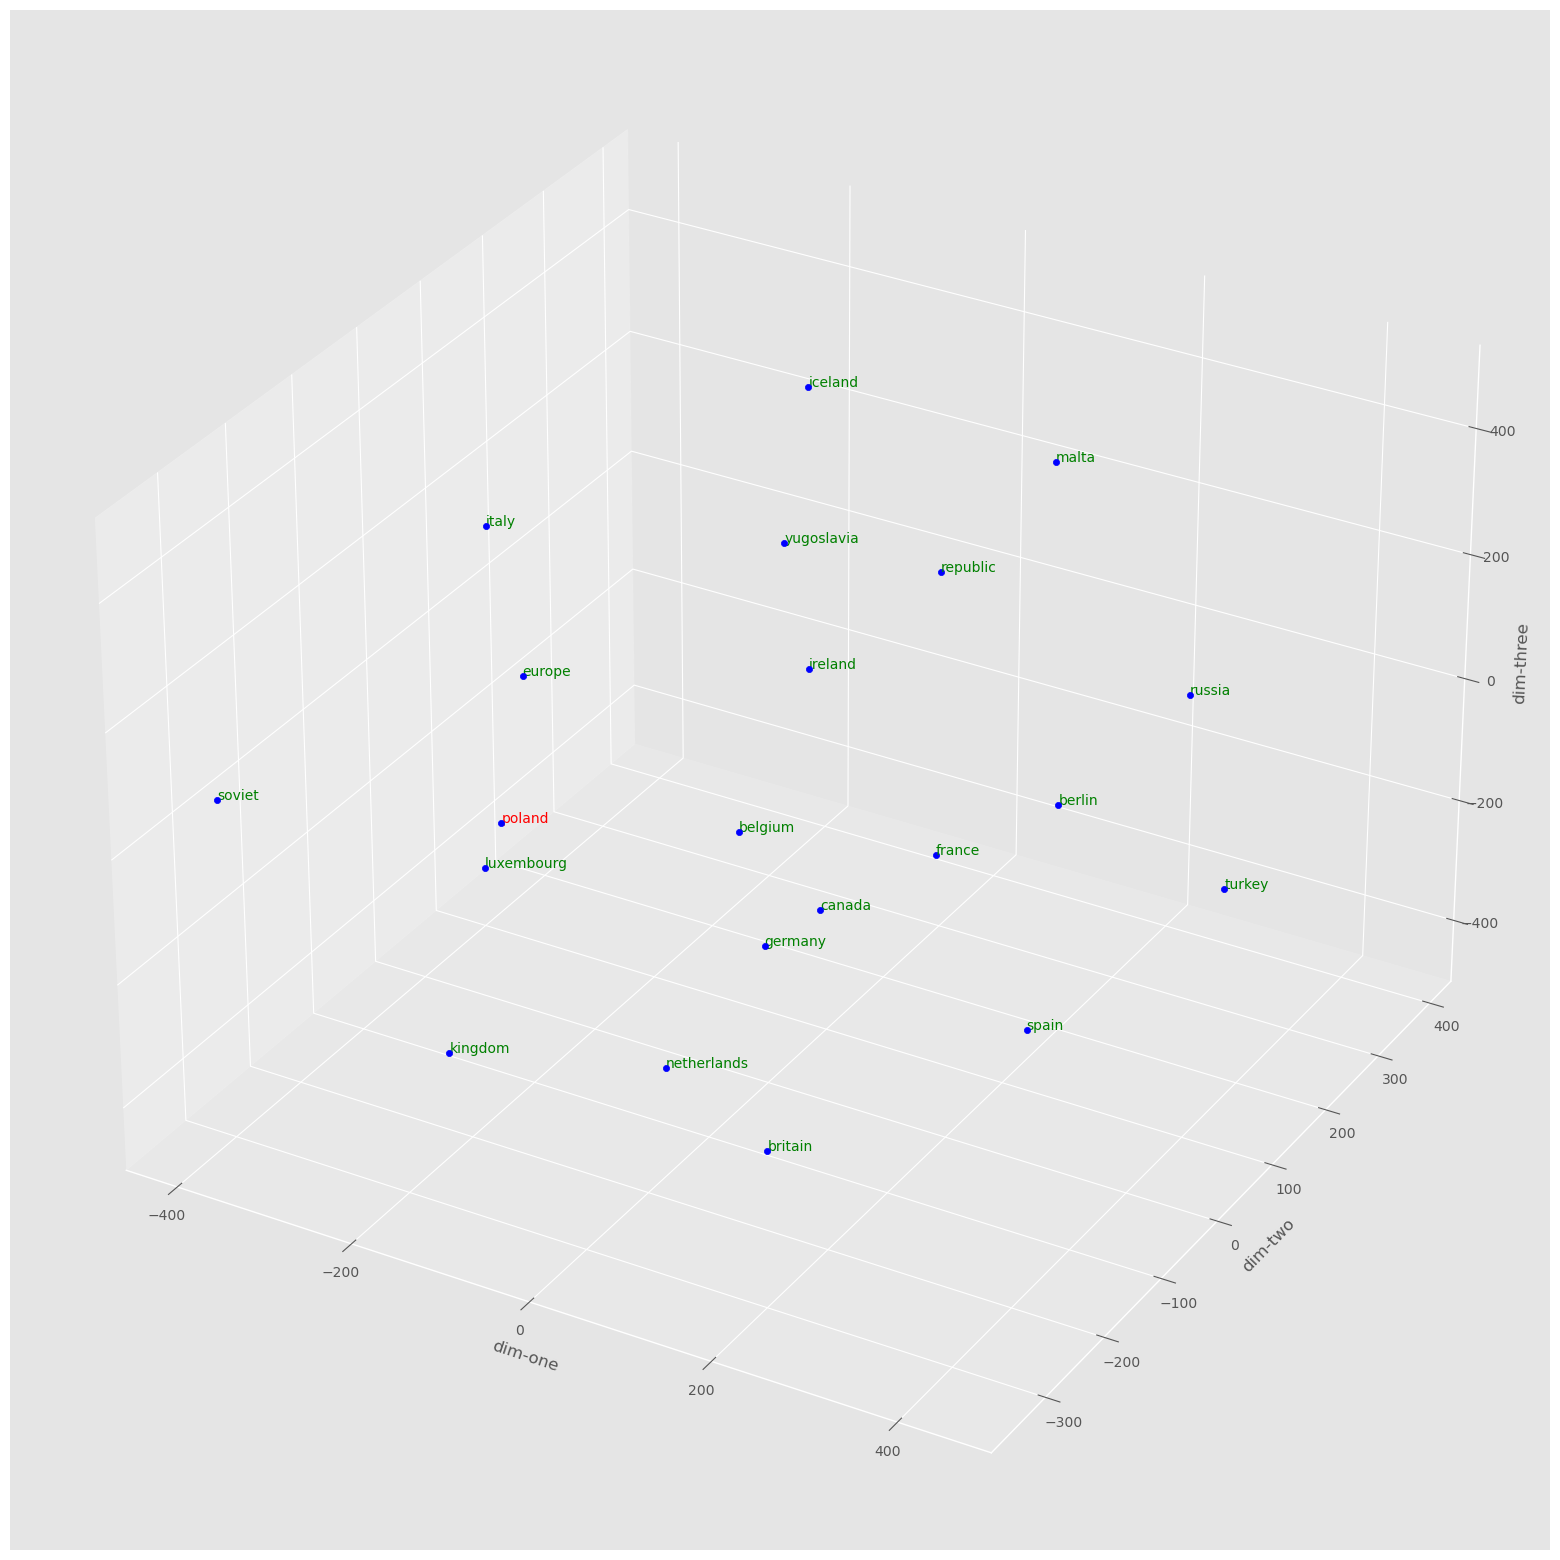

In [60]:
plot3D_with_labels(word='poland', k=20, model= my_best_rnn)

--- 
<div style="text-align: center"> <span style="color:green">GOOD LUCK WITH YOUR ASSIGNMENT 2!</span> </div>
<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>